In [1]:
!nvidia-smi

Thu Jul 16 05:29:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
import shutil, os

In [21]:
#UPLOAD kaggle.json (AFTER DOWNLOADING FROM KAGGLE ACCOUNT)
shutil.move('/content/kaggle.json','/root/.kaggle/')

'/root/.kaggle/kaggle.json'

In [22]:
!kaggle

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: too few arguments


In [23]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:34<00:00, 89.3MB/s]
100% 2.29G/2.29G [00:34<00:00, 72.0MB/s]


In [ ]:
!unzip /content/*.zip  && rm /content/*.zip

In [25]:
import numpy as np 
import pandas as pd 
import os, random
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import PIL
from PIL import Image

Using TensorFlow backend.


### OVERSAMPLING

In [29]:
rm -r /content/chest_xray/chest_xray/

In [30]:
tr_numfnames = [len(os.listdir('/content/chest_xray/train/NORMAL')),len(os.listdir('/content/chest_xray/train/PNEUMONIA'))]
print(tr_numfnames)

[1341, 3875]


In [31]:
max_num = np.max(tr_numfnames)
max_class = np.argmax(tr_numfnames)
print(max_class)

1


In [ ]:
if max_class == 1:
    gapnum = tr_numfnames[1] - tr_numfnames[0]
    print(gapnum)
    min_fnames = os.listdir('/content/chest_xray/train/NORMAL/')

    min_fnames = np.random.choice(min_fnames,gapnum,replace = True)
    #print(len(min_fnames))
    for i in range(len(min_fnames)):
        #print(min_fnames[i])
        fname = min_fnames[i][:-5]+'_'+str(i)+'.jpeg'
        shutil.copy('/content/chest_xray/train/NORMAL/'+min_fnames[i],'/content/chest_xray/train/NORMAL/'+fname)

    print([len(os.listdir('/content/chest_xray/train/NORMAL')),len(os.listdir('/content/chest_xray/train/PNEUMONIA'))])

else:

    gapnum = tr_numfnames[0] - tr_numfnames[1]

    min_fnames = os.listdir('/content/chest_xray/train/PNEUMONIA/')

    min_fnames = np.random.choice(min_fnames,gapnum, replace = True)

    for i in range(len(min_fnames)):
        #print(min_fnames[i])
        fname = min_fnames[i][:-5]+'_'+str(i)+'.jpeg'
        shutil.copy('/content/chest_xray/train/PNEUMONIA/'+min_fnames[i],'/content/chest_xray/train/PNEUMONIA/'+fname)

    print([len(os.listdir('/content/chest_xray/train/NORMAL')),len(os.listdir('/content/chest_xray/train/PNEUMONIA'))])

### PREPROCESS INPUT

In [37]:
def preprocess_input(X):
    return 2*((X-np.max(X))/(np.max(X)-np.min(X)))-1

### DATA GENERATORS

In [52]:
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
    width_shift_range=6.0,
    height_shift_range=6.0,
    brightness_range=[0.85,1.15],
    preprocessing_function = preprocess_input)
training_set = train_datagen.flow_from_directory('/content/chest_xray/train/',
        target_size=(256,256),
        batch_size=32,
        class_mode='binary')

Found 7750 images belonging to 2 classes.


In [53]:
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
val_set = val_datagen.flow_from_directory('/content/chest_xray/val/',
        target_size=(256,256),
        batch_size=32,
        class_mode='binary')

Found 16 images belonging to 2 classes.


In [81]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_set = train_datagen.flow_from_directory('/content/chest_xray/test/',
        target_size=(256,256),
        batch_size=16,
        class_mode='binary',
        shuffle=False)

Found 624 images belonging to 2 classes.


# **PREVEIWING THE IMAGES**

**THE IMAGE OF PNEUMONIC LUNG**

In [ ]:
image="/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
PIL.Image.open(image)

**THE IMAGE OF NORMAL LUNG**

In [ ]:
image="/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg"
PIL.Image.open(image)

# **BUILDING THE CNN**

**INITIALISING THE CNN**

In [216]:
cnn = tf.keras.models.Sequential()

**STEP-1 CONVOLUTION LAYER**

In [217]:
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3 ,
                               activation='relu',input_shape=[256,256,3]))

**STEP-2 POOLING**

In [218]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides = 2))

**ADDING SECOND CONVOLUTION LAYER**

In [219]:
cnn.add(tf.keras.layers.Conv2D(filters=256 , kernel_size=3 ,
                               activation='relu'))

#remove input_shape this is used to connect 1st layer to input layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=256 , kernel_size=3 ,
                               activation='relu'))

#remove input_shape this is used to connect 1st layer to input layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=512 , kernel_size=3 ,
                               activation='relu'))

#remove input_shape this is used to connect 1st layer to input layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=512 , kernel_size=3 ,
                               activation='relu'))

#remove input_shape this is used to connect 1st layer to input layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

**STEP-4 FLATTENING**

In [220]:
cnn.add(tf.keras.layers.Flatten())

**STEP-4 FULL CONNECTION**

In [221]:
cnn.add(tf.keras.layers.Dense(units=1024,activation='relu'))
#128 hidden neurons

**STEP-5 OUTPUT LAYER**

In [222]:
cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

In [223]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 256)     295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 60, 256)       590080    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 512)      

# **TRAINING THE CNN**

**COMPILING THE CNN**

In [224]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(0.0001,decay=0.00001),loss = 'binary_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC()])

**TRAINING THE CNN ON TRAINING SET AND EVALUATING ON VALIDATION SET**

In [226]:
cnn.fit(x = training_set , validation_data=val_set , epochs = 10)

Epoch 1/10
243/243 [==============================] - 296s 1s/step - loss: 0.1613 - accuracy: 0.9408 - auc_2: 0.9832 - val_loss: 1.1013 - val_accuracy: 0.6250 - val_auc_2: 0.7578
Epoch 2/10
243/243 [==============================] - 294s 1s/step - loss: 0.1460 - accuracy: 0.9472 - auc_2: 0.9856 - val_loss: 0.8081 - val_accuracy: 0.6875 - val_auc_2: 0.7656
Epoch 3/10
243/243 [==============================] - 296s 1s/step - loss: 0.1317 - accuracy: 0.9537 - auc_2: 0.9879 - val_loss: 0.6598 - val_accuracy: 0.8125 - val_auc_2: 0.8438
Epoch 4/10
243/243 [==============================] - 297s 1s/step - loss: 0.1334 - accuracy: 0.9524 - auc_2: 0.9876 - val_loss: 0.4829 - val_accuracy: 0.7500 - val_auc_2: 0.9141
Epoch 5/10
243/243 [==============================] - 298s 1s/step - loss: 0.1218 - accuracy: 0.9573 - auc_2: 0.9894 - val_loss: 0.5651 - val_accuracy: 0.8125 - val_auc_2: 0.8281
Epoch 6/10
243/243 [==============================] - 297s 1s/step - loss: 0.1218 - accuracy: 0.9568 - au

In [69]:
print("Loss of the model is - " , cnn.evaluate(test_set)[0]*100 , "%")
print("Accuracy of the model is - " , cnn.evaluate(test_set)[1]*100 , "%")

20/20 [==============================] - 17s 860ms/step - loss: 0.3897 - accuracy: 0.8510 - auc_1: 0.9374
Loss of the model is -  38.97256553173065 %
20/20 [==============================] - 17s 858ms/step - loss: 0.4290 - accuracy: 0.8381 - auc_1: 0.9273
Accuracy of the model is -  83.81410241127014 %


**MAKING A SINGLE PREDICITION**

In [73]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/content/chest_xray/test/NORMAL/NORMAL2-IM-0381-0001.jpeg',target_size=(256,256)) 
#we change size to 64,64 same as in training and test set
#convert PIL into array as predict accept 2d array
test_image = image.img_to_array(test_image)
#in data pre. our network is trained in batches even if we apply predicion on single image we need to specify as image
test_image = np.expand_dims(test_image, axis=0)
#we are adding dim which is batch ... batch is first dim because first we have dim then in batch we have image color etc.. so axis-0
result = cnn.predict(test_image)
if result[0][0]== 1 :
  prediction = 'PNEUMONIA'
else:
  prediction = 'NORMAL'
print(prediction)


NORMAL


In [227]:
y_true = np.array([])
y_pred = np.array([])
for i in range(39):
    X,y = test_set.next()
    preds = cnn.predict(X)
    y_true = np.append(y_true,y)
    y_pred = np.append(y_pred,preds)

### Metrics (DO NOT TOUCH THIS)

In [159]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_curve, confusion_matrix, average_precision_score
import seaborn as sns

In [146]:
#util_wk2
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)
    
    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)
    
    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    
    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence, 
                            spec=specificity,sens=sensitivity, ppv=get_ppv, 
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df

def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):
    
    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs


In [156]:
def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = target_names[i] + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

In [148]:
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = target_names[i] + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()

In [273]:
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = np.zeros((2,2))
    cm[0,0] = np.sum((y_true==1) & (y_pred>0.5))
    cm[0,1] = np.sum((y_true==0) & (y_pred>0.5))
    cm[1,0] = np.sum((y_true==1) & (y_pred<0.5))
    cm[1,1] = np.sum((y_true==0) & (y_pred<0.5))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    if class_labels==None:
        class_labels = ['1','0']
    
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    fig.savefig('Confusion_Matrix.png')
    plt.show()

In [206]:
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = list(metric_dfs.keys())
    fig,axs = plt.subplots(len(metrics),1,sharey=True,figsize = (4,16))
    for i in range(len(metrics)):
        ci = metric_dfs[metrics[i]][['Mean '+metrics[i]+' (CI 5%-95%)']].values[0]
        ci_mean,ci_ints = ci[0].split(' ')
        ci_mean = float(ci_mean)
        ci_min,ci_max = list(map(float,ci_ints.strip('()').split('-')))
        ci_err = (ci_max-ci_min)/2
        
        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

### Metrics PLots

In [ ]:
y_true = y_true.astype('int')

In [ ]:
y_pred_th = y_pred_th.round()
y_pred_th = y_pred_th.astype('int')
print(y_pred_th)

In [247]:
get_performance_metrics(y_true.reshape(-1,1),y_pred.reshape(-1,1),['PNEUMONIA'])

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
PNEUMONIA,384,169,65,6,0.886,0.625,0.985,0.722,0.855,0.966,0.961,0.915,0.5


In [230]:
GCI = get_confidence_intervals(y_true.reshape(-1,1),y_pred.reshape(-1,1),['PNEUMONIA'])

In [231]:
GCI['AUC']

,Mean AUC (CI 5%-95%)
PNEUMONIA,0.96 (0.95-0.97)


In [232]:
GCI['Accuracy']

,Mean Accuracy (CI 5%-95%)
PNEUMONIA,0.89 (0.87-0.91)


In [233]:
GCI['Sensitivity']

,Mean Sensitivity (CI 5%-95%)
PNEUMONIA,0.98 (0.98-0.99)


In [234]:
GCI['Specificity']

,Mean Specificity (CI 5%-95%)
PNEUMONIA,0.73 (0.70-0.76)


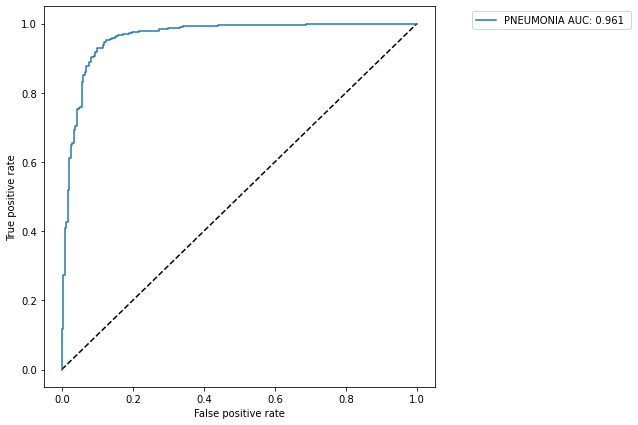

In [235]:
 get_roc_curve(y_true.reshape(-1,1),y_pred.reshape(-1,1),['PNEUMONIA'])

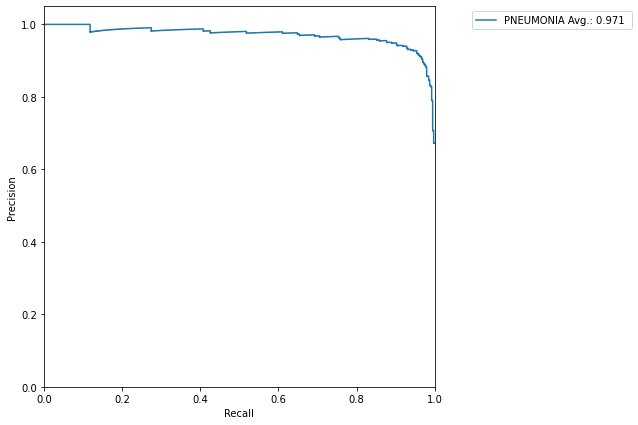

In [236]:
get_PR_curve(y_true.reshape(-1,1),y_pred.reshape(-1,1),['PNEUMONIA'])

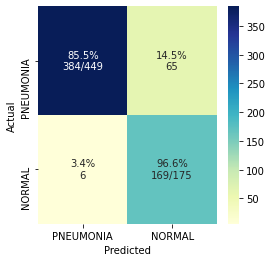

In [275]:
plot_confusion_matrix(y_true,y_pred,['PNEUMONIA','NORMAL'])

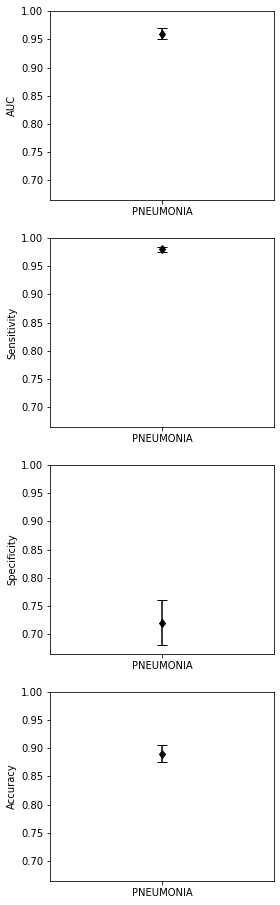

In [240]:
plot_perf_metrics_errbars(y_true.reshape(-1,1),y_pred.reshape(-1,1),['PNEUMONIA'])